# Figures for EGU 2025 Poster

In [ ]:
import os

%load_ext autoreload
%autoreload 2

import math
import numpy as np
import pandas as pd
import geopandas as gpd
import pygmt
import verde as vd
import xarray as xr
from polartoolkit import fetch, maps, regions, utils
import pathlib
import pickle
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from synthetic_bathymetry_inversion import ice_shelf_stats, synthetic, plotting
from invert4geom import utils as inv_utils
from invert4geom import plotting as inv_plotting

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Antarctic Ice Shelf Analysis

In [2]:
ice_shelves = ice_shelf_stats.get_ice_shelves()
ice_shelves

INFO:synthetic_bathymetry_inversion:Number of unmerged ice shelves: 180
INFO:synthetic_bathymetry_inversion:Combining 2 Ronne_Filchner sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 7 Abbot sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 5 Wordie sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 3 Getz sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 2 Ross sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 2 Walgreen sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 2 Rydberg sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 2 LarsenD sub-shelves
INFO:synthetic_bathymetry_inversion:Number of removed sub-shelves: 25
INFO:synthetic_bathymetry_inversion:Number of merged ice shelves: 164


,NAME,Regions,TYPE,geometry,area_km
0,Ross,West,FL,"POLYGON ((-240677.184 -678259.006, -240038.274...",480428.37
1,Ronne_Filchner,West,FL,"POLYGON ((-1006734.891 880592.98, -1006335.923...",427041.70
2,Amery,East,FL,"POLYGON ((2134701.422 618463.117, 2131452.011 ...",60797.28
3,LarsenC,Peninsula,FL,"POLYGON ((-2235724.269 1271352.188, -2235828.5...",47443.51
4,Riiser-Larsen,East,FL,"POLYGON ((-592166.317 1592824.258, -593783.16 ...",42913.14
...,...,...,...,...,...
159,Perkins,West,FL,"POLYGON ((-1129608.753 -1201300.734, -1130034....",7.01
160,Paternostro,East,FL,"POLYGON ((824294.485 -2115301.607, 823916.673 ...",6.55
161,Arneb,East,FL,"POLYGON ((333867.825 -1897953.452, 333673.461 ...",6.41
162,Falkner,East,FL,"POLYGON ((425350.532 -1726631.609, 423726.753 ...",5.69


In [3]:
# read from files
min_dist = xr.open_dataarray("../results/ice_shelves/antarctica_min_dist.nc")
antarctic_bed_points = pd.read_csv(
    "../results/ice_shelves/antarctica_constraints.csv.gz",
    sep=",",
    header=0,
    index_col=None,
    encoding="utf-8",
    compression="gzip",
)

INFO:pyogrio._io:Created 164 records


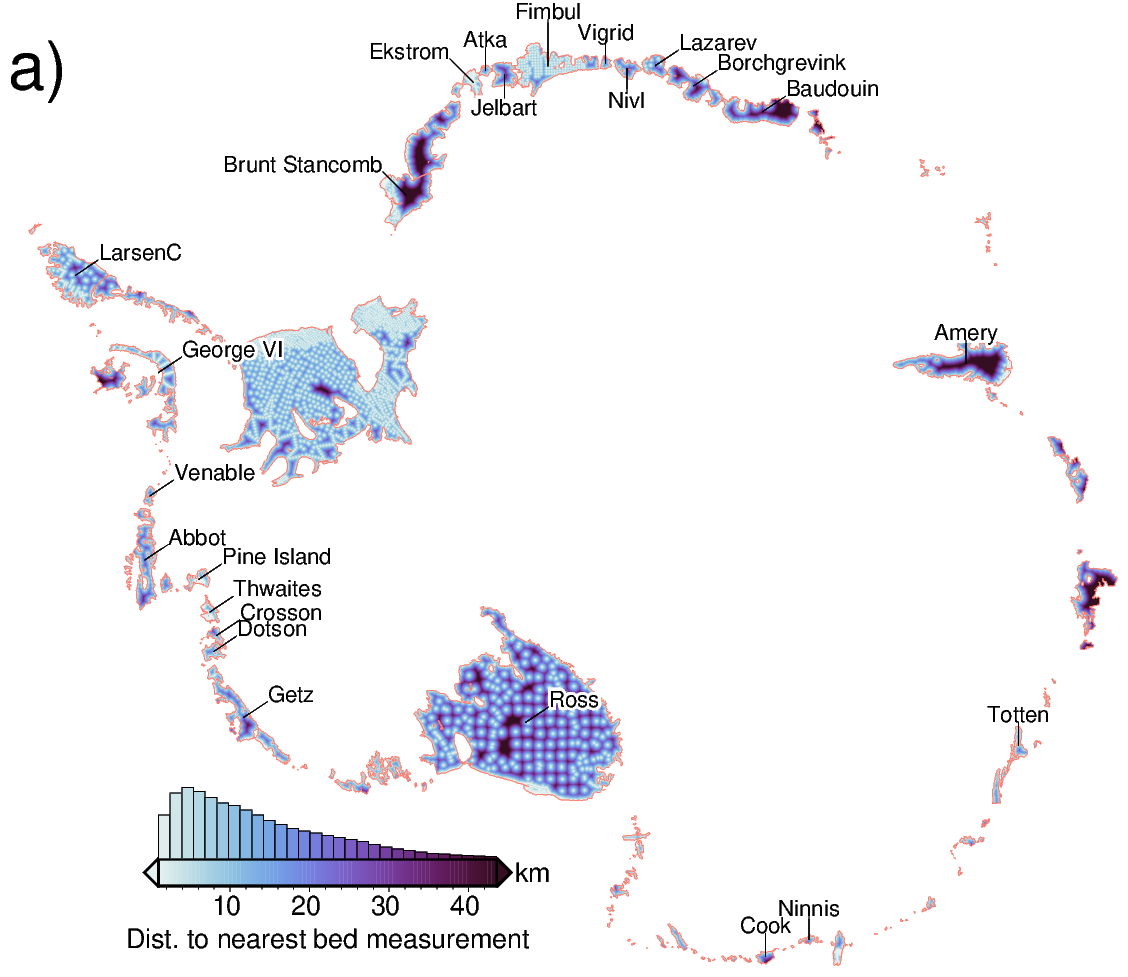

In [92]:
# define region around antarctica with a buffer
reg = utils.region_to_bounding_box(
    gpd.read_file(fetch.antarctic_boundaries(version="Coastline")).bounds.values[0]
)
reg = vd.pad_region(reg, 50e3)

fig = maps.plot_grd(
    min_dist,
    region=reg,
    fig_height=12,
    frame=False,
    cmap="dense",
    robust=True,
    hist=True,
    hist_bin_num=30,
    cbar_label="Dist. to nearest bed measurement",
    cbar_font="18p,Helvetica",
    cbar_width_perc=.3,
    cbar_height_perc=.08,
    cbar_yoffset=-1.5,
    cbar_xoffset=-3,
    cbar_hist_height=1,
    cbar_unit="km",
)
fig.plot(
    ice_shelves,
    pen="0.2p,salmon",
)


df = ice_shelves[ice_shelves.NAME.isin(ice_shelf_stats.inverted_shelves)]
# df = ice_shelves.iloc[0:10]

# plot shelves with labels above
names = ["Totten", "Cook", "Ninnis", "Amery", "Vigrid", "Atka"]
ice_shelf_stats.plot_ice_shelf_names(
    fig,
    df[df.NAME.isin(names)],
    font="8p,Helvetica",
    shadow_font="2p,white",
    offset="0c/.3c+v.2p",
    justify="BC",
)
names1 = ["Fimbul",]
ice_shelf_stats.plot_ice_shelf_names(
    fig,
    df[df.NAME.isin(names1)],
    font="8p,Helvetica",
    shadow_font="2p,white",
    offset="0c/.6c+v.2p",
    justify="BC",
)

# plot shelves with labels above and to left
names2 = ["Brunt_Stancomb", "Ekstrom",]
ice_shelf_stats.plot_ice_shelf_names(
    fig,
    df[df.NAME.isin(names2)],
    font="8p,Helvetica",
    shadow_font="2p,white",
    offset="-.3c/.3c+v.2p",
    justify="BR",
)

# plot shelves with labels below
names3=["Jelbart", "Nivl",]
ice_shelf_stats.plot_ice_shelf_names(
    fig,
    df[df.NAME.isin(names3)],
    font="8p,Helvetica",
    shadow_font="2p,white",
    offset="0c/-.3c+v.2p",
    justify="TC",
)

# plot remaning shelves with labels above and to right
ice_shelf_stats.plot_ice_shelf_names(
    fig,
    df[~df.NAME.isin(names+names1+names2+names3)],
    font="8p,Helvetica",
    shadow_font="2p,white",
    offset=".3c/.2c+v.2p",
    justify="BL",
)

fig.text(
    justify="TL",
    position="TL",
    offset=".1c/-.1c",
    text="a)",
    font="24p,Helvetica,black",
    no_clip=True,
)

fig.show(dpi=200)

In [6]:
dfs = []
for i, row in ice_shelves.iterrows():
    try:
        dfs.append(
            pd.read_csv(
                (f"../results/ice_shelves/{row.NAME}_grav_anomalies.csv.gz")
            )
        )
    except FileNotFoundError:
        print(f"File not found for {row.NAME}")

grav_df = pd.concat(dfs)

grav_grids = []
for col in [
    "gravity_disturbance",
    "topo_free_disturbance",
    "reg",
    "res",
    "error"
]:
    grd = pygmt.xyz2grd(
        x=grav_df.easting,
        y=grav_df.northing,
        z=grav_df[col],
        region=reg,
        spacing=5e3,
    ).rename(col)

    # mask to ice shelf regions
    grd = utils.mask_from_shp(
        shapefile=ice_shelves,
        xr_grid=grd,
        invert=False,
        masked=True,
    )
    grav_grids.append(grd)

grav_grid = xr.merge(grav_grids)
grav_grid

xyz2grd [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
xyz2grd [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
xyz2grd (gmtapi_init_grdheader): Please select compatible -R and -I values
xyz2grd [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
xyz2grd [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
xyz2grd (gmtapi_init_grdheader): Please select compatible -R and -I values
xyz2grd [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
xyz2grd [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
xyz2grd (gmtapi_init_grdheader): Please select compatible -R and -I values
xyz2grd [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
xyz2grd [WAR

<xarray.Dataset> Size: 19MB
Dimensions:                (y: 898, x: 1072)
Coordinates:
  * y                      (y) float64 7kB -2.194e+06 -2.189e+06 ... 2.291e+06
  * x                      (x) float64 9kB -2.558e+06 -2.553e+06 ... 2.795e+06
Data variables:
    gravity_disturbance    (y, x) float32 4MB nan nan nan nan ... nan nan nan
    topo_free_disturbance  (y, x) float32 4MB nan nan nan nan ... nan nan nan
    reg                    (y, x) float32 4MB nan nan nan nan ... nan nan nan
    res                    (y, x) float32 4MB nan nan nan nan ... nan nan nan
    error                  (y, x) float32 4MB nan nan nan nan ... nan nan nan
Attributes:
    Conventions:   CF-1.7
    title:         
    history:       gmt xyz2grd @GMTAPI@-S-I-D-V-T-N-000000 -G@GMTAPI@-S-O-G-G...
    description:   
    actual_range:  [nan nan]
    long_name:     z

INFO:pyogrio._io:Created 164 records


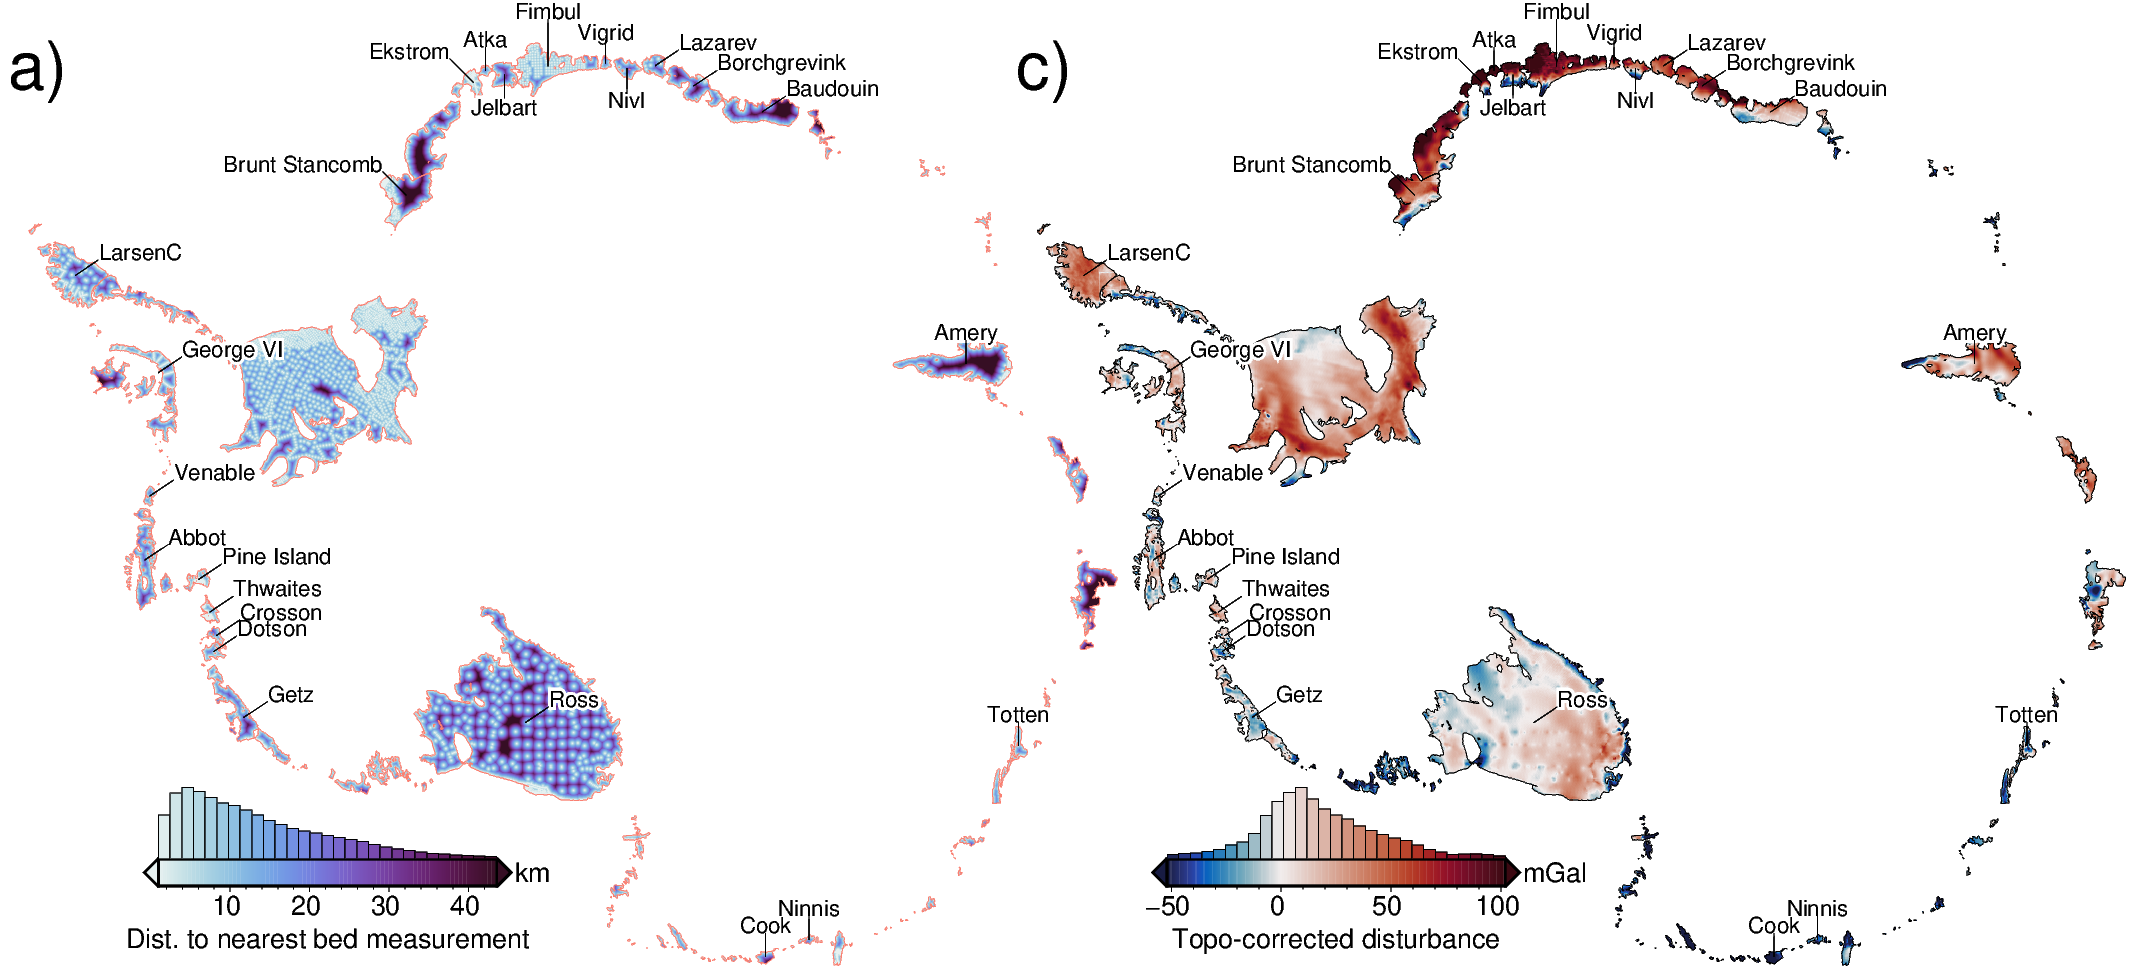

In [ ]:
fig = maps.plot_grd(
    grav_grid.topo_free_disturbance,
    fig=fig,
    origin_shift="x",
    xshift_amount=.87, #.85 too small, .9 too big
    region=reg,
    fig_height=12,
    frame=False,
    cmap="balance+h0",
    robust=True,
    hist=True,
    hist_bin_num=30,
    cbar_label="Topo-corrected disturbance",
    cbar_font="18p,Helvetica",
    cbar_width_perc=.3,
    cbar_height_perc=.08,
    cbar_yoffset=-1.5,
    cbar_xoffset=-3,
    cbar_hist_height=1,
    cbar_unit="mGal",

)

fig.plot(
    ice_shelves,
    pen="0.2p,black",
)

df = ice_shelves[ice_shelves.NAME.isin(ice_shelf_stats.inverted_shelves)]
# df = ice_shelves.iloc[0:10]

# plot shelves with labels above
names = ["Totten", "Cook", "Ninnis", "Amery", "Vigrid", "Atka"]
ice_shelf_stats.plot_ice_shelf_names(
    fig,
    df[df.NAME.isin(names)],
    font="8p,Helvetica",
    shadow_font="2p,white",
    offset="0c/.3c+v.2p",
    justify="BC",
)
names1 = ["Fimbul",]
ice_shelf_stats.plot_ice_shelf_names(
    fig,
    df[df.NAME.isin(names1)],
    font="8p,Helvetica",
    shadow_font="2p,white",
    offset="0c/.6c+v.2p",
    justify="BC",
)

# plot shelves with labels above and to left
names2 = ["Brunt_Stancomb", "Ekstrom",]
ice_shelf_stats.plot_ice_shelf_names(
    fig,
    df[df.NAME.isin(names2)],
    font="8p,Helvetica",
    shadow_font="2p,white",
    offset="-.3c/.3c+v.2p",
    justify="BR",
)

# plot shelves with labels below
names3=["Jelbart", "Nivl",]
ice_shelf_stats.plot_ice_shelf_names(
    fig,
    df[df.NAME.isin(names3)],
    font="8p,Helvetica",
    shadow_font="2p,white",
    offset="0c/-.3c+v.2p",
    justify="TC",
)

# plot remaning shelves with labels above and to right
ice_shelf_stats.plot_ice_shelf_names(
    fig,
    df[~df.NAME.isin(names+names1+names2+names3)],
    font="8p,Helvetica",
    shadow_font="2p,white",
    offset=".3c/.2c+v.2p",
    justify="BL",
)

fig.text(
    justify="TL",
    position="TL",
    offset=".1c/-.1c",
    text="c)",
    font="24p,Helvetica,black",
    no_clip=True,
)


fig.show(dpi=200)

In [94]:
fig.savefig(
    "../poster/figures/Antarctic_grids.png",
    dpi=2000,
)

In [19]:
df = pd.read_csv("../results/ice_shelves/ice_shelf_gravity_stats.csv", index_col=None)

# turn back into geodataframe
ice_shelf_stats_gdf_full = gpd.GeoDataFrame(
    df,
    geometry=gpd.GeoSeries.from_wkt(df['geometry'], crs="EPSG:3031"),
    crs="EPSG:3031",
)
ice_shelf_stats_gdf = ice_shelf_stats_gdf_full[ice_shelf_stats_gdf_full.area_km >1000]

Text(0, 0.5, '')

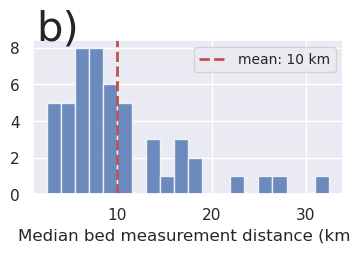

In [99]:
df = ice_shelf_stats_gdf

fig, ax1 = plt.subplots(
    figsize=(4, 2),
)

ax1.hist(
    df.median_constraint_distance,
    bins=20,
    alpha=.8,
)
mean = round(df.median_constraint_distance.mean())
ax1.axvline(
    mean,
    color='r',
    linestyle='dashed',
    linewidth=2,
    label=f'mean: {mean} km')
median = round(df.median_constraint_distance.median())
# ax1.axvline(
#     median,
#     color='g',
#     linestyle='dashed',
#     linewidth=2,
#     label=f'median: {median} km')
ax1.legend(fontsize='small')

ax1.annotate(
    "b)",
    (0.01, 1),
    xycoords='axes fraction',
    fontsize=30,
)

ax1.set_xlabel("Median bed measurement distance (km)")
ax1.set_ylabel(None)

Text(0, 0.5, '')

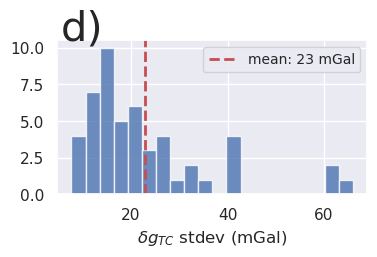

In [ ]:
df = ice_shelf_stats_gdf

fig, ax2 = plt.subplots(
    figsize=(4, 2),
)

ax2.hist(
    df.topo_free_disturbance_stdev,
    bins=20,
    alpha=.8,
)
mean = round(df.topo_free_disturbance_stdev.mean())
ax2.axvline(
    mean,
    color='r',
    linestyle='dashed',
    linewidth=2,
    label=f'mean: {mean} mGal')
median = round(df.topo_free_disturbance_stdev.median())
# ax2.axvline(
#     median,
#     color='g',
#     linestyle='dashed',
#     linewidth=2,
#     label=f'median: {median} mGal')
ax2.legend(fontsize='small')

ax2.annotate(
    "d)",
    (0.01, 1),
    xycoords='axes fraction',
    fontsize=30,
)


ax2.set_xlabel("$\delta g_{{TC}}$ stdev (mGal)")
ax2.set_ylabel(None)

# Synthetic testing

In [53]:
ensemble_path = (
    "../results/Ross_Sea/ensembles/Ross_Sea_ensemble_01_constraint_spacing_vs_regional_strength_with_density_estimation"
)

ensemble_fname = f"{ensemble_path}.csv"

sampled_params_df = pd.read_csv(ensemble_fname)

In [55]:
ds = sampled_params_df.set_index(["median_proximity", "regional_stdev"]).to_xarray()

for p in ["reg_stdev", "topo_free_disturbance_stdev"]:
    for i, row in ice_shelf_stats_gdf.iterrows():
        inversion_rmse = ds.final_inversion_rmse.sel(
            median_proximity=row.median_constraint_distance,
            regional_stdev=row[p],
            method="nearest",
        ).values
        topo_improvement_rmse = ds.final_inversion_topo_improvement_rmse.sel(
            median_proximity=row.median_constraint_distance,
            regional_stdev=row[p],
            method="nearest",
        ).values
        ice_shelf_stats_gdf.loc[i, f"inversion_rmse_from_{p}"] = inversion_rmse
        ice_shelf_stats_gdf.loc[i, f"topo_improvement_rmse_from_{p}"] = (
            topo_improvement_rmse
        )

In [58]:
predict_on = "topo_free_disturbance_stdev"

shelves_to_plot = ice_shelf_stats_gdf.copy()

# exclude shelves outsite param limits of Ensemble 1
# round lims to ints to include shelves on the edge
shelves_to_plot = shelves_to_plot[
    shelves_to_plot.median_constraint_distance.between(
        math.floor(sampled_params_df.median_proximity.min())-1,
        math.ceil(sampled_params_df.median_proximity.max())+1,
    )
    & shelves_to_plot[predict_on].between(
        math.floor(sampled_params_df.regional_stdev.min())-1,
        math.ceil(sampled_params_df.regional_stdev.max())+1,
    )
]

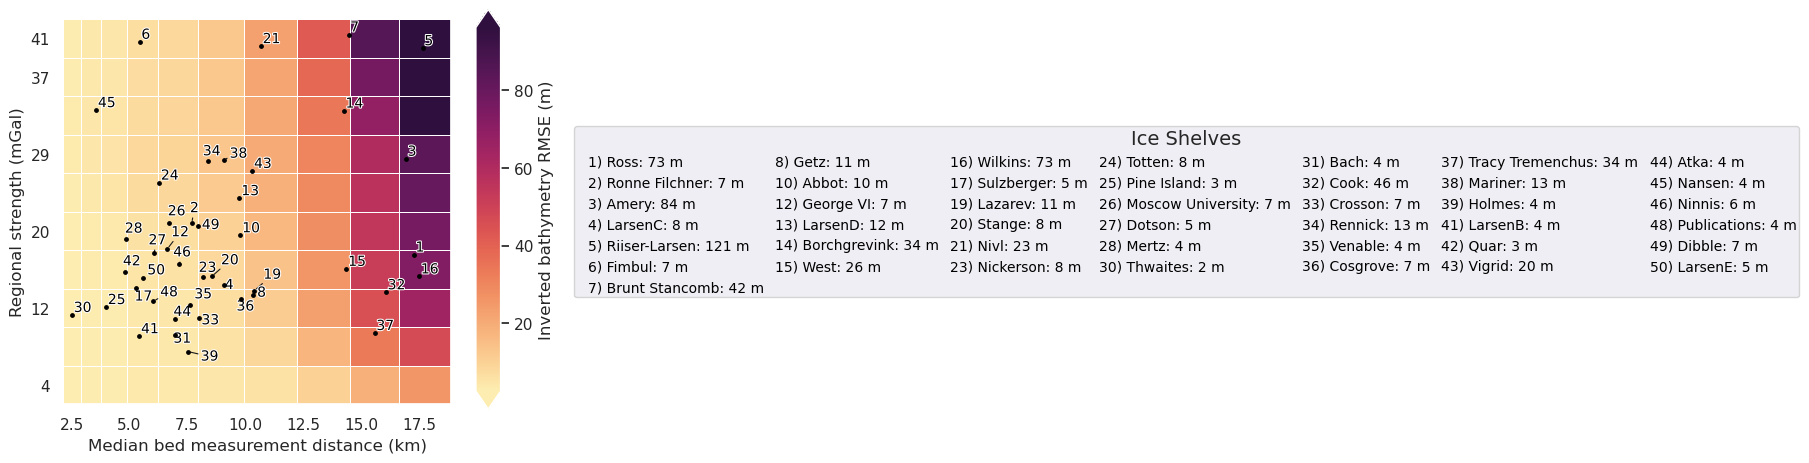

In [249]:
fig = plotting.plot_2var_ensemble(
    sampled_params_df,
    figsize=(5, 5),
    x="median_proximity",
    x_title="Median bed measurement distance (km)",
    y="regional_stdev",
    y_title="Regional strength (mGal)",
    background="final_inversion_rmse",
    background_title="Inverted bathymetry RMSE (m)",
    background_robust=True,
    background_cpt_lims=utils.get_min_max(
        sampled_params_df.final_inversion_rmse,
        robust=True,

    ),
    constrained_layout=False,
)
ax = fig.get_axes()[0]
ax.grid(True)

# # add second x axis with number of constraints
# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# x_tick_vals = sampled_params_df.median_proximity.unique()
# x_tick_labels = sampled_params_df.constraint_numbers.unique()
# inds_to_remove = [-2,-3,-5, -7, -9]
# x_tick_vals = np.delete(x_tick_vals, inds_to_remove)
# x_tick_labels = np.delete(x_tick_labels, inds_to_remove)
# x_tick_labels = [round(x) for x in x_tick_labels]
# ax2.set_xticks(x_tick_vals)
# ax2.set_xticklabels(x_tick_labels)
# ax2.grid(False)
# ax2.set_xlabel("Number of bed measurements")
# ax2.xaxis.set_ticks_position("bottom")
# ax2.xaxis.set_label_position("bottom")
# ax2.spines["bottom"].set_position(("outward", 40))

# specify y ticks
yvals = list(sampled_params_df.regional_stdev.unique())[::2]+ [sampled_params_df.regional_stdev.max()]
ax.set_yticks(yvals)
ax.set_yticklabels([round(x) for x in yvals])

df = shelves_to_plot
ice_shelf_stats.add_shelves_to_ensembles(
    x="median_constraint_distance",
    y=predict_on,
    ice_shelves=df,
    ax=ax,
    # legend=False,
    legend_cols=7,
    col_to_add_to_label=f"inversion_rmse_from_{predict_on}",
    seperate_inverted_shelves=False,
    fontsize = 10,
)

plt.minorticks_off()

# fig.savefig(
#     "../paper/figures/Ross_Sea_constraint_vs_regional_ensemble_bathy_error_2var.png",
#     bbox_inches="tight",
#     dpi=300,
# )

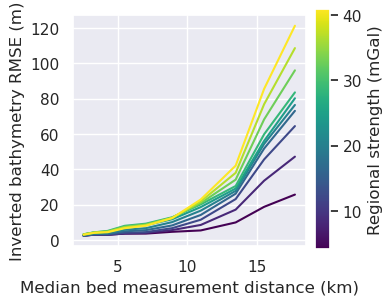

In [234]:
fig = plotting.plot_ensemble_as_lines(
    sampled_params_df,
    figsize=(3, 3),
    x="median_proximity",
    x_label="Median bed measurement distance (km)",
    y="final_inversion_rmse",
    y_label="Inverted bathymetry RMSE (m)",
    groupby_col="regional_stdev",
    cbar_label="Regional strength (mGal)",
    markersize=0,
)
# ax = fig.get_axes()[0]
# plt.gcf().text(0.01, 0.95, "c)", fontsize=16, va="top", ha="left")

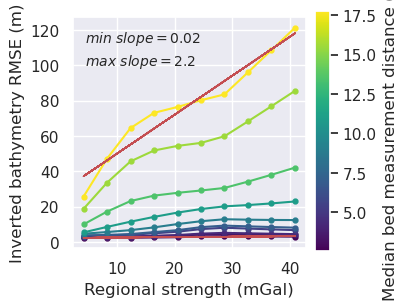

In [235]:
fig = plotting.plot_ensemble_as_lines(
    sampled_params_df,
    figsize=(3, 3),
    x="regional_stdev",
    x_label="Regional strength (mGal)",
    y="final_inversion_rmse",
    y_label="Inverted bathymetry RMSE (m)",
    groupby_col="median_proximity",
    cbar_label="Median bed measurement distance (km)",
    trend_line=True,
    slope_min_max=True,
    # slope_mean=True,
    slope_decimals=2,
)
# plt.gcf().text(0.15, 0.95, "d)", fontsize=16, va="top", ha="left")


In [126]:
inversion_region = (-40e3, 110e3, -1600e3, -1400e3)
sampled_params_df.constraint_numbers.unique()


array([  4,   7,  12,  22,  38,  68, 119, 210, 369, 650])

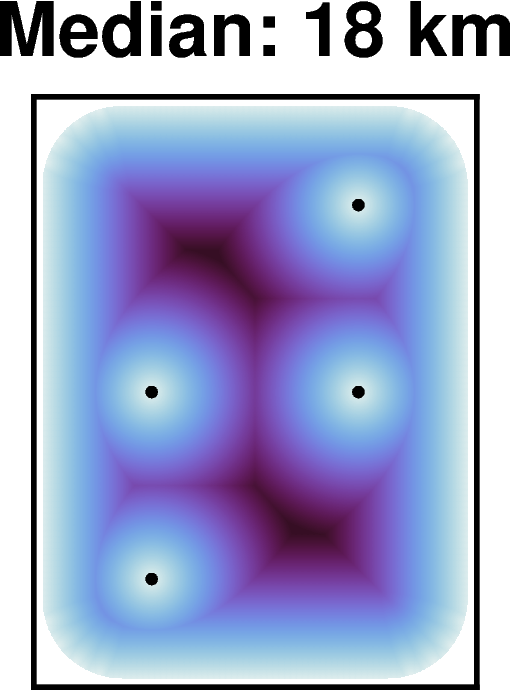

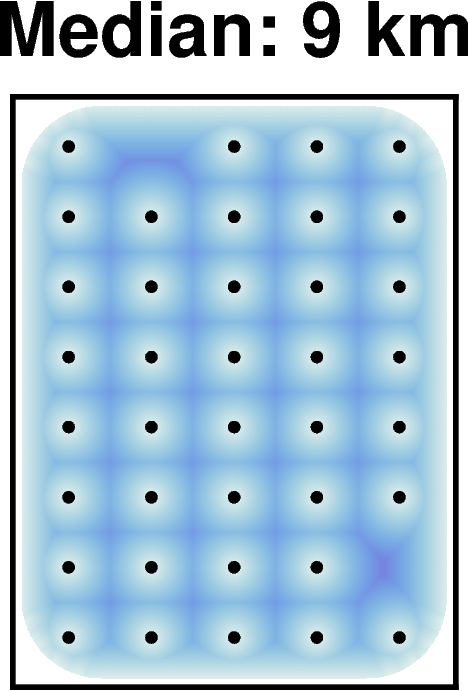

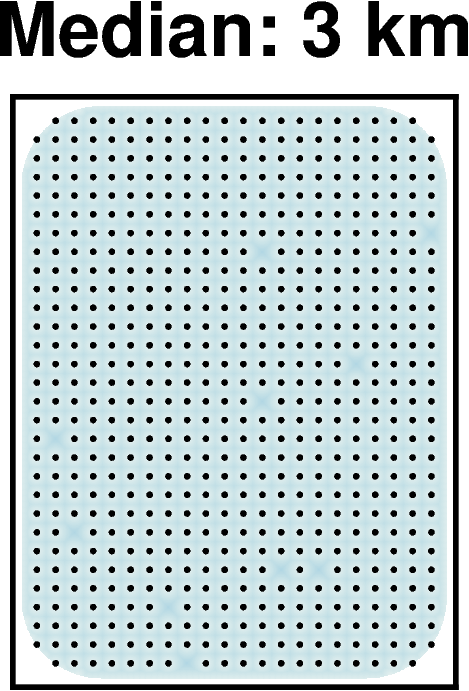

In [142]:
for num in [4, 38, 650]:
    row = sampled_params_df[sampled_params_df.constraint_numbers == num].iloc[0]
    constraint_points = pd.read_csv(row.constraint_points_fname)

    # calculate min dist between each grid cell and nearest constraint
    coords = vd.grid_coordinates(
        region=inversion_region,
        spacing=100,
    )
    grid = vd.make_xarray_grid(coords, np.ones_like(coords[0]), data_names="z").z
    min_dist = inv_utils.dist_nearest_points(
        constraint_points,
        grid,
    ).min_dist/1e3

    # mask to the ice shelf outline
    min_dist = utils.mask_from_shp(
        shapefile="../results/Ross_Sea_outline.shp",
        xr_grid=min_dist,
        invert=False,
        masked=True,
    )
    if num > 200:
        style = "p.05c"
    else:
        style = "p.1c"
    fig = maps.plot_grd(
        min_dist,
        fig_height=5,
        title=f"Median: {round(row.median_proximity)} km",
        cmap="dense",
        colorbar=False,
        cpt_lims=(0, 50),
        points=constraint_points[constraint_points.inside],
        points_style=style,
        )
    fig.show()

In [144]:
sampled_params_df.regional_stdev.unique()

array([ 4.09158544,  8.18317088, 12.27475632, 16.36634176, 20.45792721,
       24.54951265, 28.64109809, 32.73268353, 36.82426897, 40.91585441])

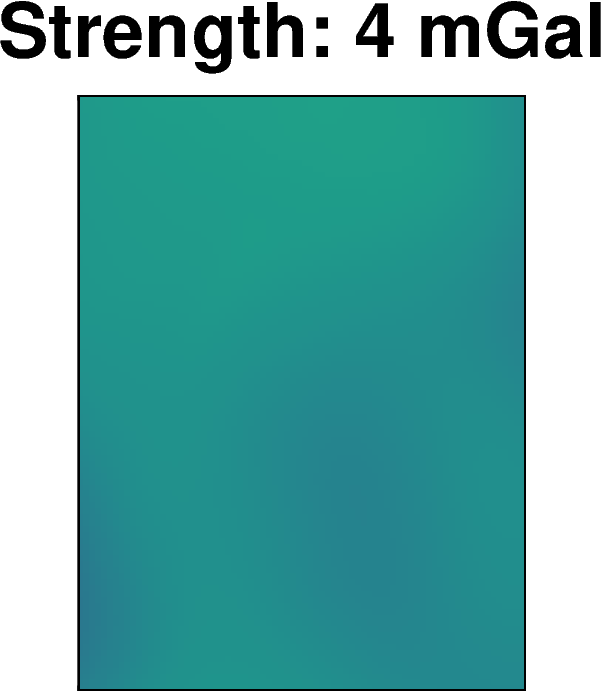

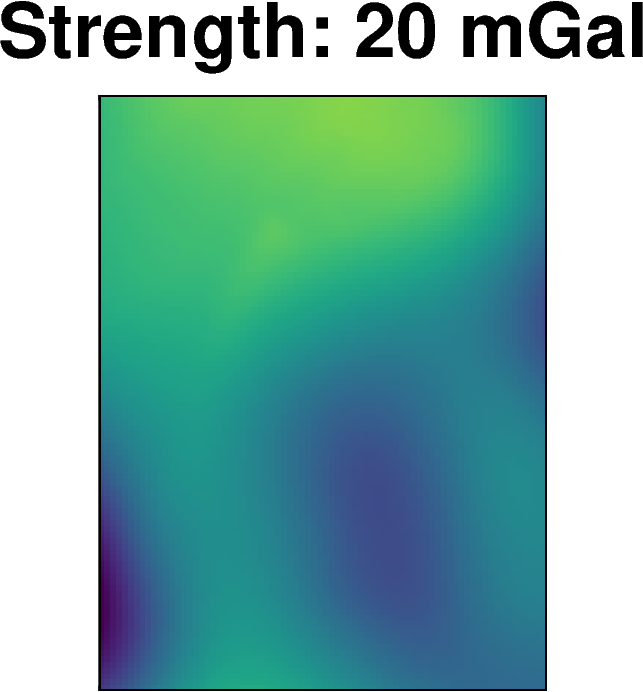

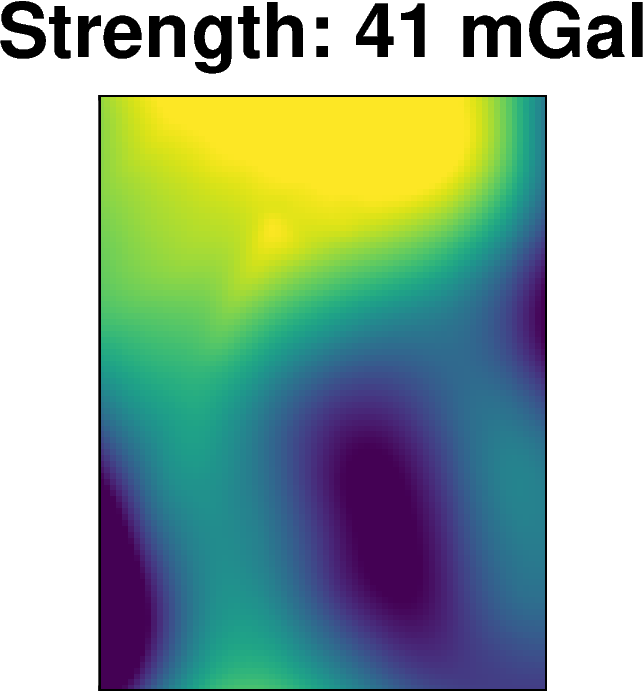

In [151]:
for num in [4, 20, 41]:
    row = sampled_params_df[round(sampled_params_df.regional_stdev) == num].iloc[0]
    grav_df = pd.read_csv(row.grav_df_fname)

    grid = grav_df.set_index(["northing", "easting"]).to_xarray().basement_grav_scaled

    fig = maps.plot_grd(
        grid,
        fig_height=5,
        title=f"Strength: {round(row.regional_stdev)} mGal",
        cmap="viridis",
        colorbar=False,
        cpt_lims=(-60, 60),
        )
    fig.show()

# Inversion plots

In [165]:
# set grid parameters
spacing = 2e3
inversion_region = (-40e3, 110e3, -1600e3, -1400e3)

true_density_contrast = 1476

bathymetry, basement, _ = synthetic.load_synthetic_model(
    spacing=spacing,
    inversion_region=inversion_region,
    buffer=spacing * 10,
    basement=True,
    zref=0,
    bathymetry_density_contrast=true_density_contrast,
    plot_gravity=False,
    plot_topography=False,
)

INFO:polartoolkit:changing grid region and spacing
INFO:polartoolkit:requested spacing (2000.0) larger than original (500.0), filtering before resampling
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
INFO:polartoolkit:converting to be reference to the WGS84 ellipsoid
INFO:polartoolkit:changing grid region and spacing
INFO:polartoolkit:changing grid region and spacing


  0%|          | 0/7676 [00:00<?, ?it/s]

  0%|          | 0/7676 [00:00<?, ?it/s]

In [176]:
bathymetry_density_contrast = 1476
bathymetry_zref = bathymetry.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    bathymetry >= bathymetry_zref,
    bathymetry_density_contrast,
    -bathymetry_density_contrast,
)

# create layer of prisms
bathymetry_prisms = inv_utils.grids_to_prisms(
    bathymetry,
    bathymetry_zref,
    density=density_grid,
)

basement_density_contrast = 2800 - 2500
basement_zref = basement.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    basement >= basement_zref,
    basement_density_contrast,
    -basement_density_contrast,
)

# create layer of prisms
basement_prisms = inv_utils.grids_to_prisms(
    basement,
    basement_zref,
    density=density_grid,
)

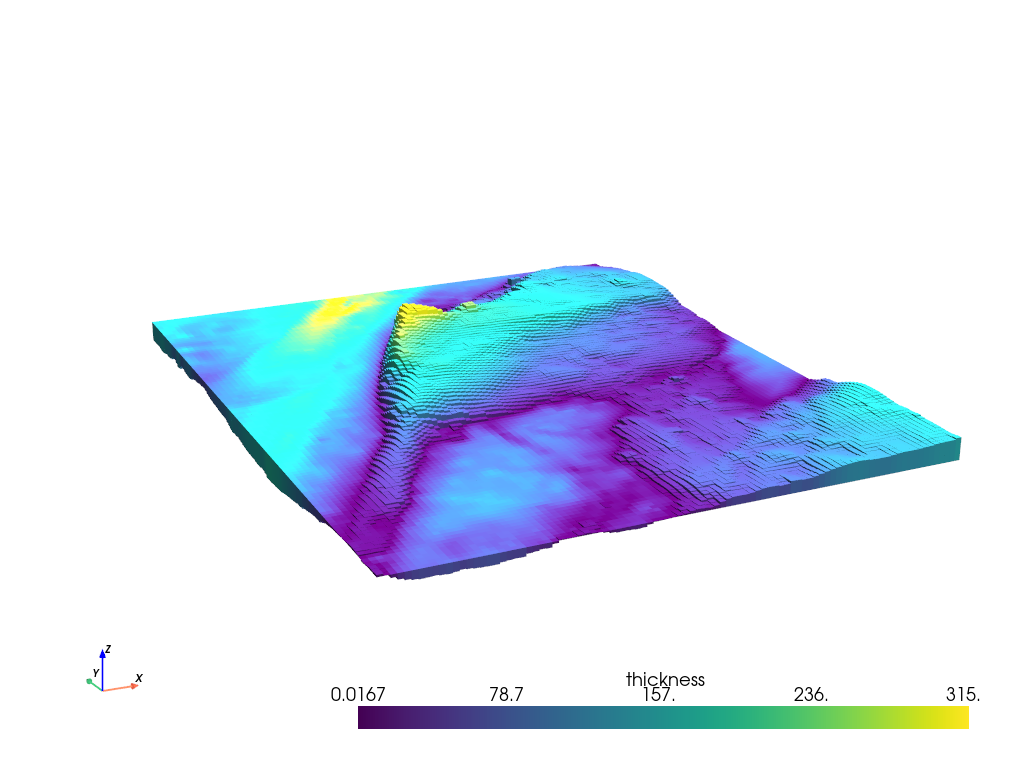

In [ ]:
inv_plotting.show_prism_layers(
    bathymetry_prisms,
    color_by="thickness",
    log_scale=False,
    zscale=100,
)

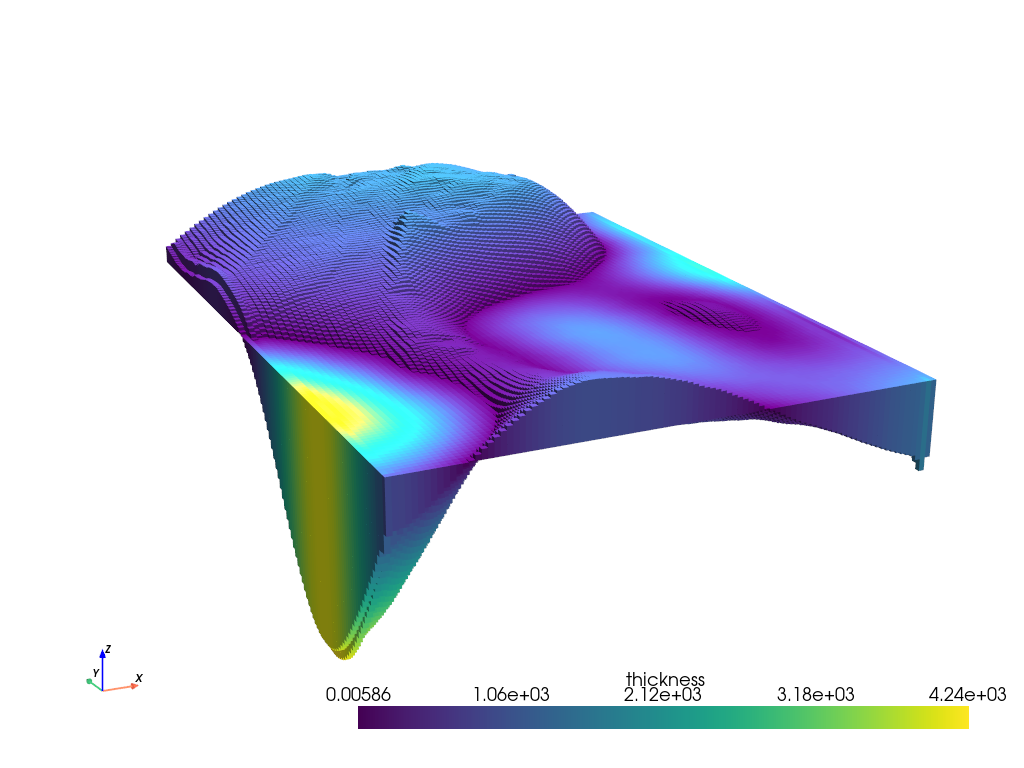

In [192]:
inv_plotting.show_prism_layers(
    basement_prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    # backend="static",
)

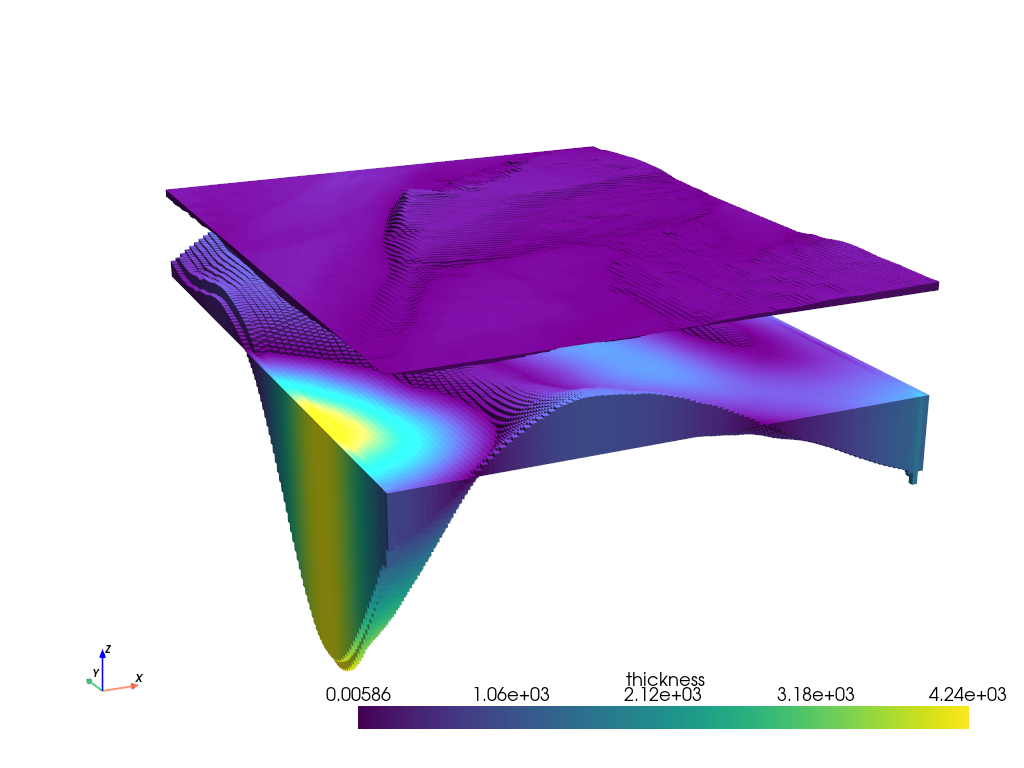

In [ ]:
inv_plotting.show_prism_layers(
    [bathymetry_prisms, basement_prisms],
    color_by="thickness",
    log_scale=False,
    zscale=20,
    # backend="static",

)

In [220]:
sampled_params_df[round(sampled_params_df.regional_stdev)==20]

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_per_10000sq_km,constraints_starting_rmse,starting_bathymetry_fname,starting_prisms_fname,starting_bathymetry_mae,starting_bathymetry_rmse,grav_df_fname,...,true_density_inversion_rmse,true_density_topo_improvement_rmse,final_inverted_bathymetry_fname,final_inversion_results_fname,final_inversion_constraints_rmse,final_inversion_rmse,final_inversion_topo_improvement_rmse,maximum_constraint_proximity,constraint_proximity_skewness,median_proximity
4,4,100.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,282.666667,0.003561,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,28.351052,46.321442,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,140.641935,-94.320493,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,2.673602,76.397586,-30.076144,51.305,0.483691,17.755
14,7,100.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,283.666667,0.006497,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,26.114630,43.370158,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,99.623022,-56.252864,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,2.237959,54.362008,-10.991850,43.175,0.462908,15.534
24,12,100.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,285.333333,0.005156,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,24.695174,41.525870,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,53.471016,-11.945146,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,1.412139,27.810191,13.715680,38.792,0.441687,13.483
34,22,100.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,288.666667,0.021868,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,21.093411,34.760296,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,22.961948,11.798348,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,1.561391,16.630969,18.129326,31.794,0.371767,10.966
44,38,100.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,294.000000,0.039079,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,14.971934,27.849600,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,11.537976,16.311624,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,1.138266,10.136220,17.713380,22.522,0.104572,8.902
54,68,100.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,304.000000,0.061987,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,12.527695,21.748223,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,6.383049,15.365174,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,1.053233,6.699684,15.048539,19.021,0.146099,7.011
64,119,100.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,321.000000,0.051151,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,9.109592,19.111870,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,5.573788,13.538082,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,1.121104,5.815013,13.296857,16.852,0.375467,5.491
74,210,100.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,350.000000,0.131169,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,6.381548,11.358149,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,3.275455,8.082695,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,0.901368,3.925676,7.432474,12.387,0.167703,4.256
84,369,100.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl..

In [222]:
row = sampled_params_df[
    (round(sampled_params_df.median_proximity) == 9) &
    (round(sampled_params_df.regional_stdev)==20)
].iloc[0]
row

constraint_numbers                                                                             38
regional_strengths                                                                          100.0
constraint_points_fname                         ../results/Ross_Sea/ensembles/Ross_Sea_ensembl...
constraints_per_10000sq_km                                                                  294.0
constraints_starting_rmse                                                                0.039079
starting_bathymetry_fname                       ../results/Ross_Sea/ensembles/Ross_Sea_ensembl...
starting_prisms_fname                           ../results/Ross_Sea/ensembles/Ross_Sea_ensembl...
starting_bathymetry_mae                                                                 14.971934
starting_bathymetry_rmse                                                                  27.8496
grav_df_fname                                   ../results/Ross_Sea/ensembles/Ross_Sea_ensembl...
regional_stdev      

In [223]:
plot_region = (-40e3, 110e3, -1600e3, -1400e3)

# constraint_points = pd.read_csv("../results/Ross_Sea/inversion_for_poster_constraint_points.csv")
# # load damping CV study
# with pathlib.Path("../results/Ross_Sea/inversion_for_poster_damping_cv_damping_cv_study.pickle").open(
#     "rb"
# ) as f:
#     damping_study = pickle.load(f)
# # load density contrast estimation study
# with pathlib.Path("../results/Ross_Sea/inversion_for_poster_density_cv_study.pickle").open("rb") as f:
#     study = pickle.load(f)
#     optimized_density = study.best_params["density_contrast"]
# optimal_results_fname = "../results/Ross_Sea/inversion_for_poster_optimal_results.pickle"
# with pathlib.Path(optimal_results_fname).open("rb") as f:
#     optimal_result = pickle.load(f)
# topo_results, grav_df, _, _ = optimal_result

# load data
grav_df = pd.read_csv(row.grav_df_fname)
starting_bathymetry = xr.load_dataarray(row.starting_bathymetry_fname)
constraint_points = pd.read_csv(row.constraint_points_fname)

# load saved inversion results
with pathlib.Path(f"{row.final_inversion_results_fname}_results.pickle").open("rb") as f:
    topo_results, grav_df, _, _ = pickle.load(f)

topo_results_grid = topo_results.set_index(["northing", "easting"]).to_xarray()
topo_results_grid = topo_results_grid.sel(
    easting=slice(plot_region[0], plot_region[1]),
    northing=slice(plot_region[2], plot_region[3]),
)
final_bathymetry = topo_results_grid.topo
starting_bathymetry = topo_results_grid.starting_topo

# clip to inversion region
final_bathymetry = final_bathymetry.sel(
    easting=slice(plot_region[0], plot_region[1]),
    northing=slice(plot_region[2], plot_region[3]),
)
starting_bathymetry = starting_bathymetry.sel(
    easting=slice(plot_region[0], plot_region[1]),
    northing=slice(plot_region[2], plot_region[3]),
)

grav_grid = grav_df.set_index(['northing', 'easting']).to_xarray()

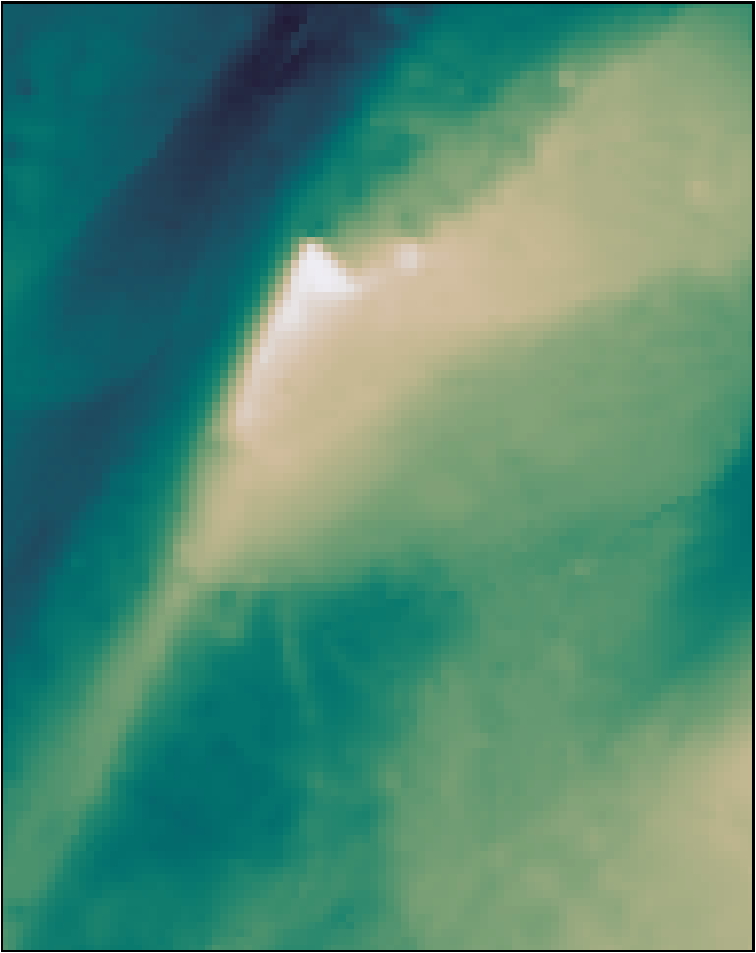

In [225]:
fig = maps.plot_grd(
    bathymetry,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    # title="Bathymetry",
    cbar_label="elevation (m)",
    cbar_font="18p,Helvetica,black",
    hist=True,
    hist_bin_num=25,
    colorbar=False,
)

fig.show()

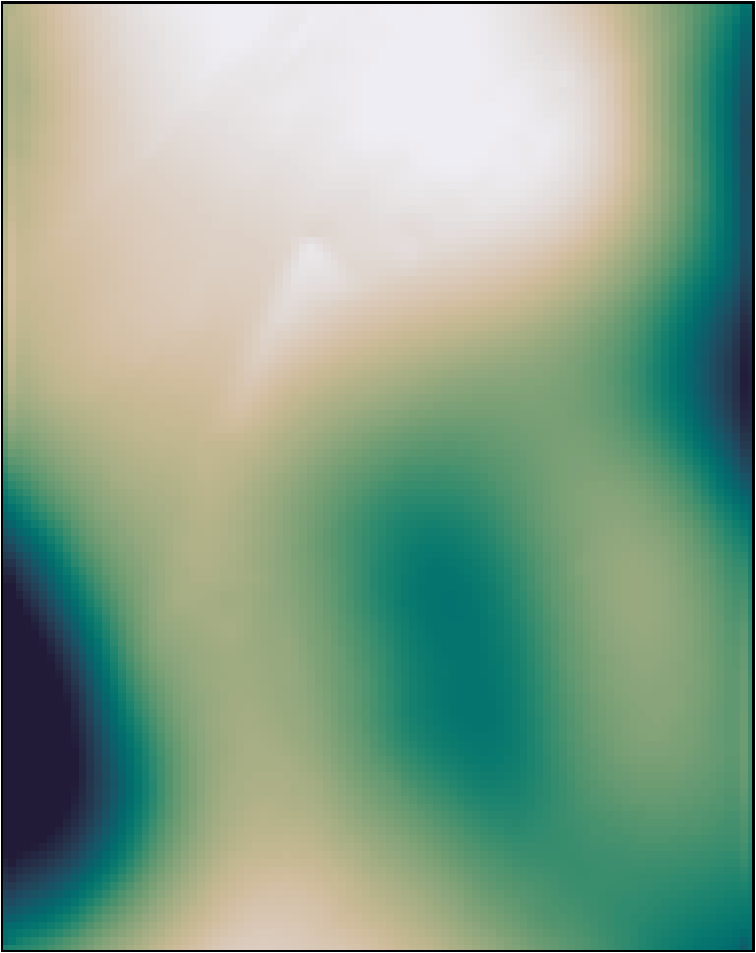

In [226]:
fig = maps.plot_grd(
    basement,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    # title="Basement",
    cbar_label="elevation (m)",
    cbar_font="18p,Helvetica,black",
    hist=True,
    hist_bin_num=25,
    colorbar=False,
    robust=True,
)

fig.show()

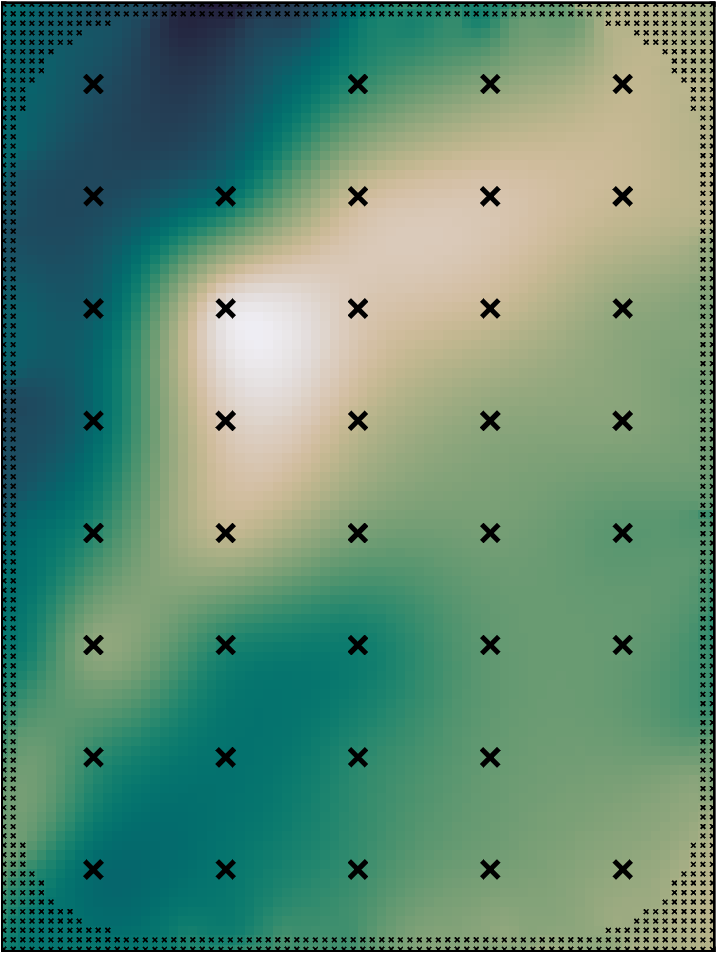

In [227]:
fig = maps.plot_grd(
    starting_bathymetry,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    # title="Starting bathymetry",
    cbar_label="elevation (m)",
    cbar_font="18p,Helvetica,black",
    hist=True,
    hist_bin_num=25,
    colorbar=False,
)
fig.plot(
    x=constraint_points.easting,
    y=constraint_points.northing,
    style="x.05c",
)
fig.plot(
    x=constraint_points[constraint_points.inside].easting,
    y=constraint_points[constraint_points.inside].northing,
    style="x.2c",
    pen="1p,black",
)
fig.show()

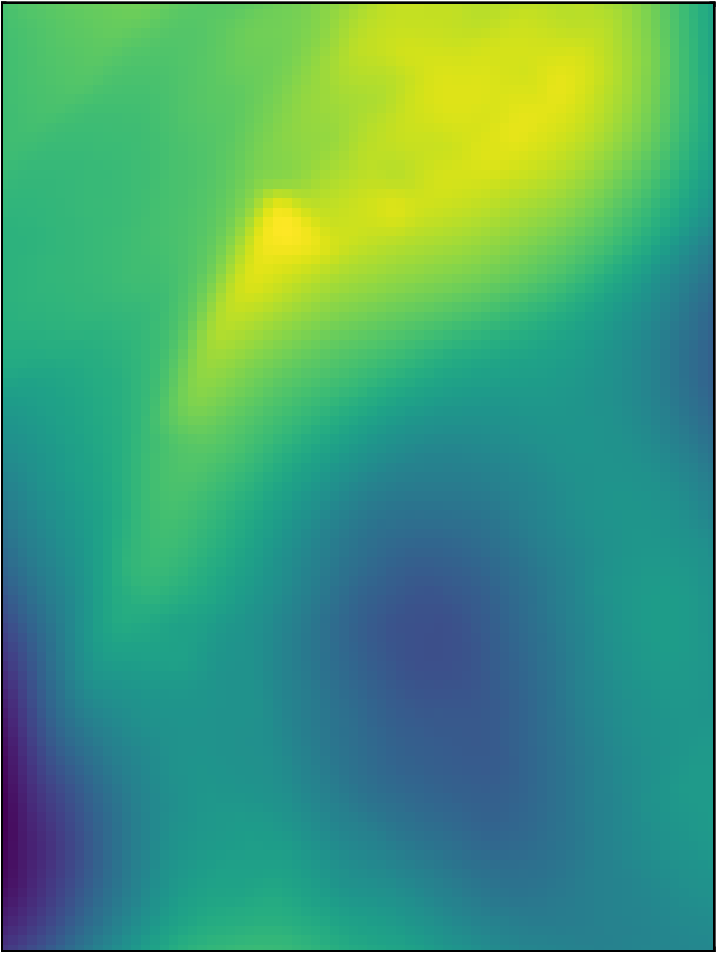

In [228]:
fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig_height=8,
    cmap="viridis",
    # title="Gravity disturbance",
    cbar_label="mGal",
    cbar_font="18p,Helvetica,black",
    hist=True,
    hist_bin_num=25,
    colorbar=False,
)
fig.show()

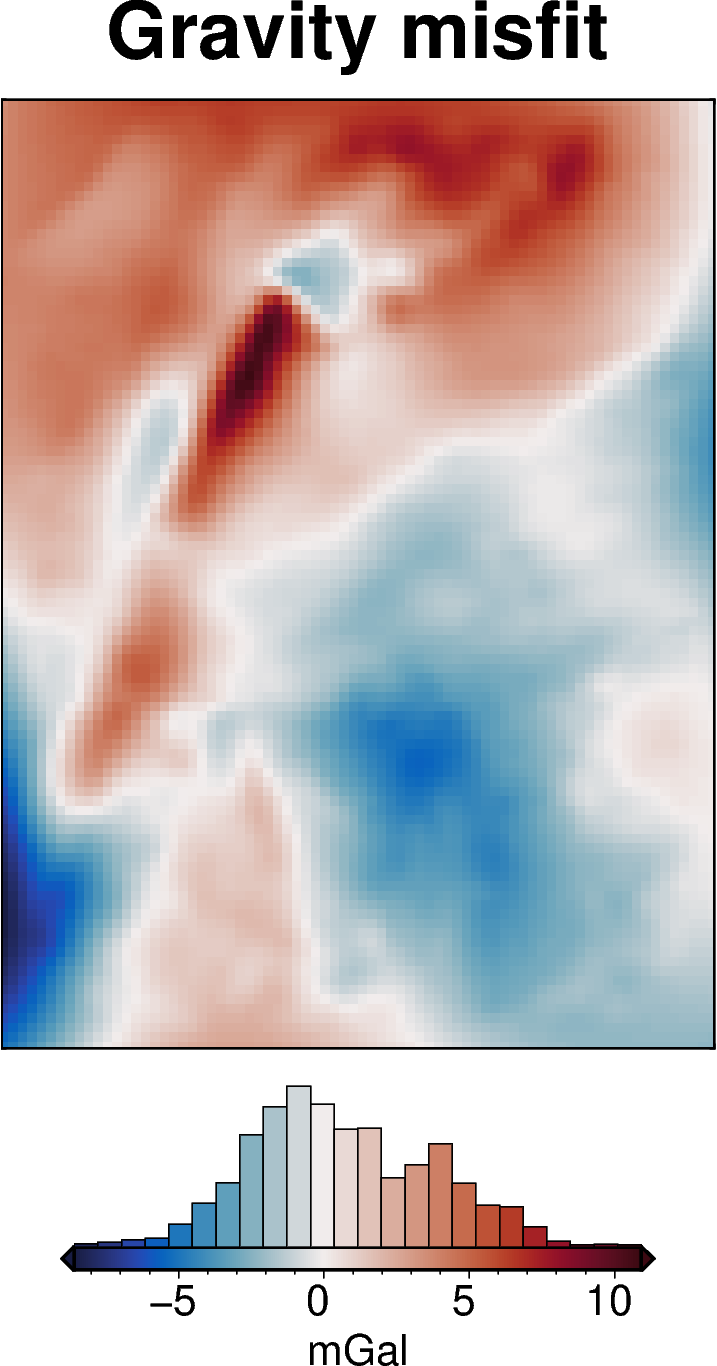

In [13]:
fig = maps.plot_grd(
    grav_grid.misfit,
    fig_height=8,
    cmap="balance+h0",
    title="Gravity misfit",
    cbar_label="mGal",
    cbar_font="18p,Helvetica,black",
    hist=True,
    hist_bin_num=25,
)
fig.show()

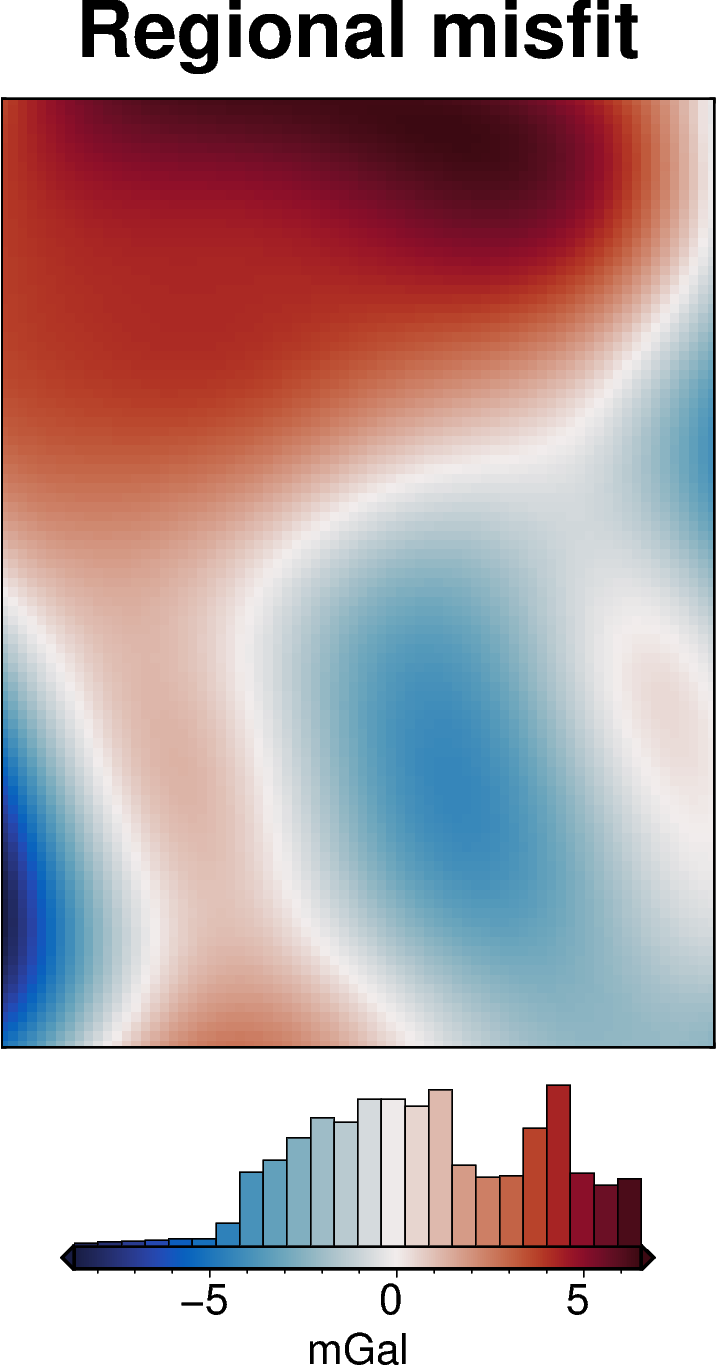

In [14]:
fig = maps.plot_grd(
    grav_grid.reg,
    fig_height=8,
    cmap="balance+h0",
    title="Regional misfit",
    cbar_label="mGal",
    cbar_font="18p,Helvetica,black",
    hist=True,
    hist_bin_num=25,
)
fig.show()

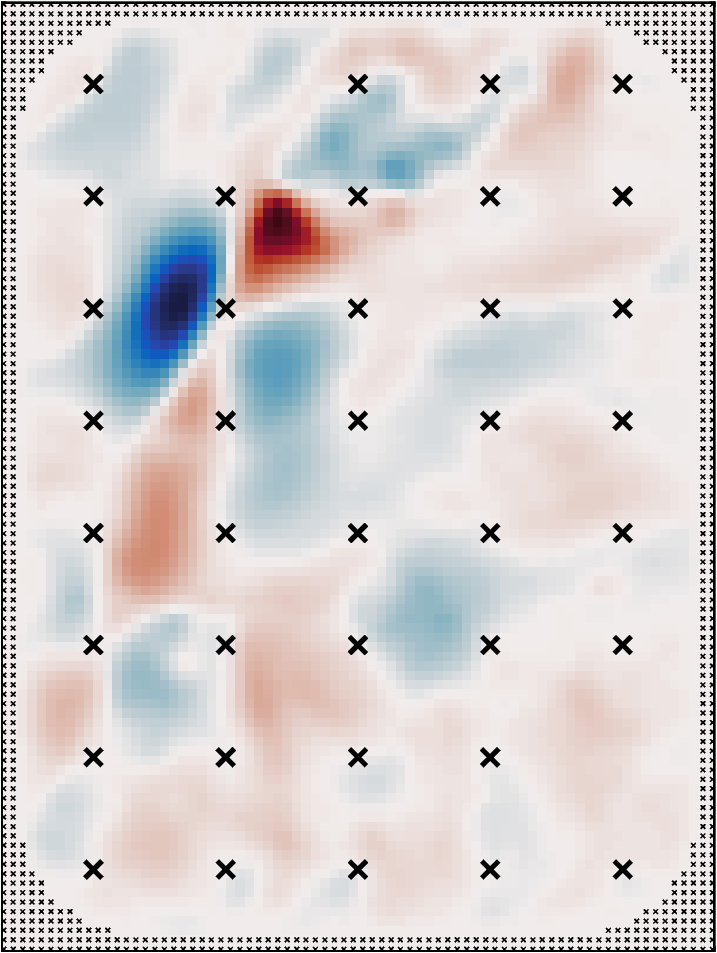

In [229]:
fig = maps.plot_grd(
    grav_grid.iter_1_initial_misfit,
    fig_height=8,
    cmap="balance+h0",
    # title="Residual misfit",
    cbar_label="mGal",
    cbar_font="18p,Helvetica,black",
    hist=True,
    hist_bin_num=25,
    colorbar=False,
)
fig.plot(
    x=constraint_points.easting,
    y=constraint_points.northing,
    style="x.05c",
)
fig.plot(
    x=constraint_points[constraint_points.inside].easting,
    y=constraint_points[constraint_points.inside].northing,
    style="x.2c",
    pen="1p,black",
)
fig.show()

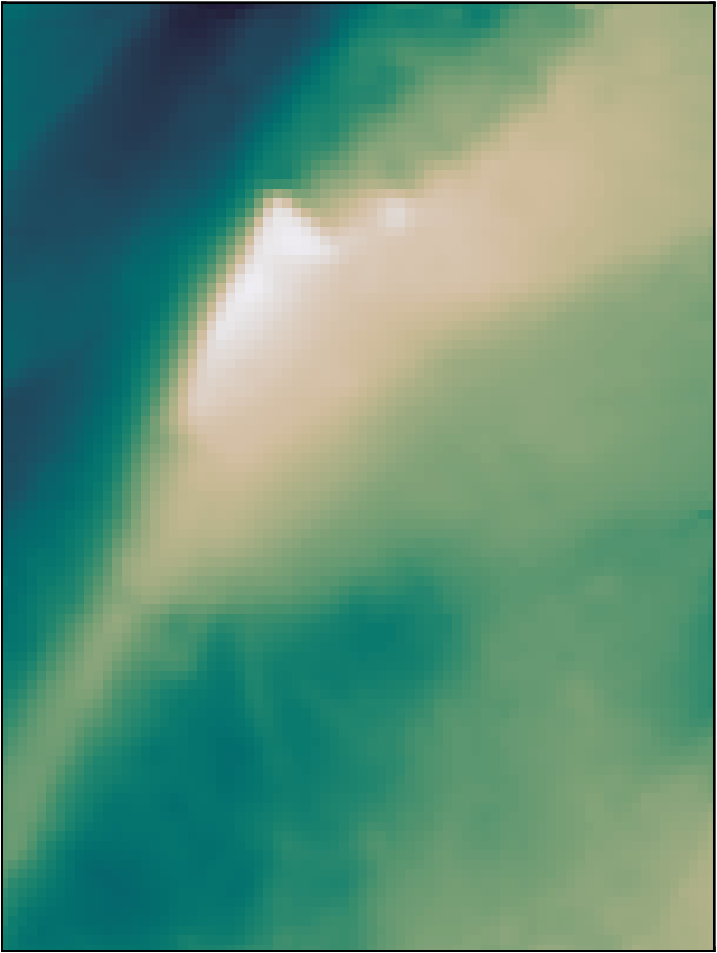

In [230]:
fig = maps.plot_grd(
    final_bathymetry,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    # title="Inverted bathymetry",
    cbar_label="elevation (m)",
    cbar_font="18p,Helvetica,black",
    hist=True,
    hist_bin_num=25,
    colorbar=False,
)
# fig.plot(
#     x=constraint_points.easting,
#     y=constraint_points.northing,
#     style="x.05c",
# )
# fig.plot(
#     x=constraint_points[constraint_points.inside].easting,
#     y=constraint_points[constraint_points.inside].northing,
#     style="x.2c",
#     pen="1p,black",
# )
fig.show()

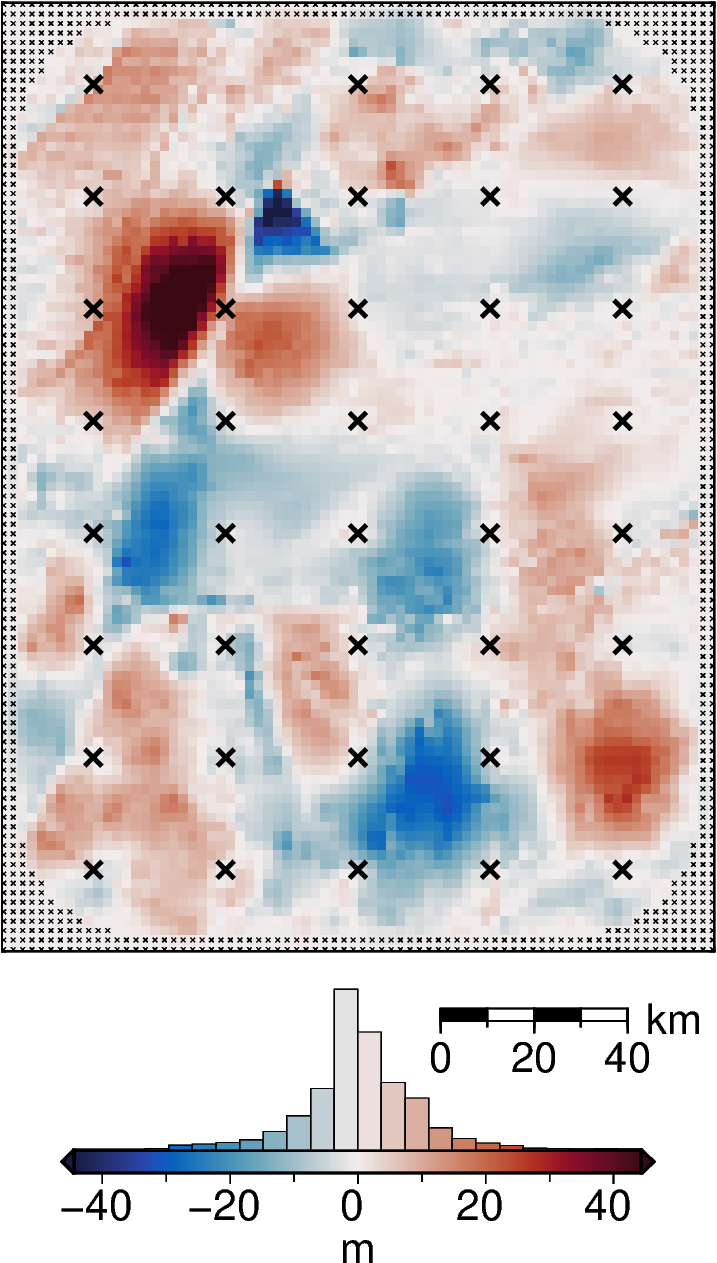

In [247]:
fig = maps.plot_grd(
    final_bathymetry-bathymetry,
    fig_height=8,
    cmap="balance+h0",
    cpt_lims=utils.get_min_max(final_bathymetry-bathymetry, absolute=True, robust=True, robust_percentiles=(0.005, 0.995)),
    # title="Error",
    cbar_label="m",
    cbar_font="18p,Helvetica,black",
    hist=True,
    hist_bin_num=25,
    # colorbar=False,
    scalebar=True,
    scalebar_position="JBR+o-2.3c/.5c",
)
fig.plot(
    x=constraint_points.easting,
    y=constraint_points.northing,
    style="x.05c",
)
fig.plot(
    x=constraint_points[constraint_points.inside].easting,
    y=constraint_points[constraint_points.inside].northing,
    style="x.2c",
    pen="1p,black",
)
fig.show()

In [232]:
utils.rmse(final_bathymetry-bathymetry)

np.float64(10.136224148791023)

In [26]:
final_bathymetry

<xarray.DataArray 'topo' (northing: 101, easting: 76)> Size: 61kB
array([[-603.24759776, -611.65024175, -617.84813161, ..., -418.94785924,
        -414.62187389, -408.59976639],
       [-598.76459142, -605.82578775, -618.91915939, ..., -417.44834754,
        -412.92155856, -406.11134426],
       [-591.45428341, -599.68731381, -617.52432098, ..., -416.88967961,
        -411.75133346, -404.65717327],
       ...,
       [-656.73406598, -657.25727671, -663.69299132, ..., -427.69763322,
        -428.59377336, -426.21582234],
       [-649.0095812 , -645.50146537, -649.57164905, ..., -432.76167083,
        -431.73034882, -431.04288041],
       [-646.61826805, -640.72076545, -643.16389974, ..., -432.89741029,
        -435.47625675, -437.74101443]], shape=(101, 76))
Coordinates:
  * northing  (northing) float64 808B -1.6e+06 -1.598e+06 ... -1.4e+06
  * easting   (easting) float64 608B -4e+04 -3.8e+04 ... 1.08e+05 1.1e+05

In [27]:
bathymetry

<xarray.DataArray 'z' (northing: 121, easting: 96)> Size: 46kB
array([[-522.2271 , -536.0397 , -557.3431 , ..., -395.08472, -394.52728,
        -385.17908],
       [-525.213  , -534.8609 , -553.671  , ..., -394.57312, -395.14993,
        -389.50003],
       [-524.30676, -532.75366, -548.4573 , ..., -392.89508, -393.21234,
        -391.5557 ],
       ...,
       [-683.0879 , -685.79474, -688.70544, ..., -521.7847 , -531.37286,
        -538.272  ],
       [-682.24994, -685.79266, -688.0536 , ..., -530.91864, -535.2167 ,
        -540.78357],
       [-683.3837 , -687.5659 , -691.45245, ..., -541.56854, -545.20917,
        -553.4231 ]], shape=(121, 96), dtype=float32)
Coordinates:
  * northing  (northing) float64 968B -1.62e+06 -1.618e+06 ... -1.38e+06
  * easting   (easting) float64 768B -6e+04 -5.8e+04 ... 1.28e+05 1.3e+05

In [25]:
_ = utils.grd_compare(
    bathymetry,
    final_bathymetry,
    hist=True,
)

INFO:polartoolkit:grid regions dont match, using inner region (-40000.0, 110000.0, -1600000.0, -1400000.0)
INFO:polartoolkit:changing grid region
INFO:polartoolkit:returning original grid


GMTInvalidInput: Invalid number of grid dimensions 'len(('y', 'x', 'northing', 'easting'))'. Must be 2.

In [ ]:
basal_melt = fetch.basal_melt().rename({"northing": "y", "easting": "x"})
buttressing = fetch.buttressing(version='max')

In [ ]:
# define region around antarctica with a buffer
reg = utils.region_to_bounding_box(
    gpd.read_file(fetch.antarctic_boundaries(version="Coastline")).bounds.values[0]
)
reg = vd.pad_region(reg, 50e3)

fig = maps.plot_grd(
    buttressing,
    region=reg,
    fig_height=12,
    frame=False,
    cmap="roma",
    reverse_cpt=True,
    cpt_lims=(-0.3, 1.3),
    hist=True,
    cbar_label="buttressing",
    cbar_font="18p,Helvetica",
    cbar_width_perc=.45,
    cbar_yoffset=-1.2,
    cbar_xoffset=-3,
    cbar_hist_height=1,
)

fig.show(dpi=500)

In [ ]:
fig = maps.plot_grd(
    basal_melt,
    fig=fig,
    origin_shift="x",
    xshift_amount=.9,
    region=reg,
    fig_height=12,
    frame=False,
    cmap="balance+h0",
    # robust=True,
    cpt_lims=[-3, 3],
    # hist=True,
    cbar_label="Basal melt rate (m/yr)",
    cbar_font="18p,Helvetica",
    cbar_width_perc=.45,
    cbar_yoffset=-1.2,
    cbar_xoffset=-3,
    cbar_hist_height=1,
)

fig.show(dpi=500)